In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Force CPU

import sys
sys.path.append(os.path.abspath(".."))  

import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor

# Project Imports
from environment.env import Simulatio4RecSys
from environment.items_selection import GreedySelector
from environment.reward_perturbator import NoPerturbator
from environment.reward_shaping import IdentityRewardShaping
from environment.citations.citation_loader import CitationsLoader
from environment.citations.citations_retrieval import CitationsRetrieval
from environment.users.citation_users_loader import CitationUsersLoader
# from environment.LLM.small_hf_llm import SmallHuggingfaceLLM
from environment.flat_obs_wrapper import FlatObsWrapper
# from environment.LLM.rater import CitationLLMRater



In [ ]:
# # environment/LLM/rater.py

# from environment.LLM.llm import LLM
# from environment.LLM.rater import LLMRater

# class CitationLLMRater(LLMRater):
#     def __init__(self, llm, current_items_features_list=[], previous_items_features_list=[], llm_render=False, llm_query_explanation=False):
#         super().__init__(llm, current_items_features_list, previous_items_features_list, llm_render, llm_query_explanation)
#         self.request_scale = "0-9"
#         self.system_prompt = (
#     "You are simulating a user's preferences for scientific papers.\n"
#     "Consider the following factors when rating a paper from 0 (not interested) to 9 (extremely interested):\n"
#     "- How closely the paper's TOPICS match the user's interests.\n"
#     "- Whether the user prefers NOVELTY (more recent papers).\n"
#     "- Whether the user prefers REPUTABILITY (highly cited papers).\n"
#     "\n"
#     "If a paper matches the user's topics AND fits their novelty/reputability preferences, rate it HIGH (8-9).\n"
#     "If it poorly matches in topics or is too old/too low-cited based on user's preferences, rate it LOW (0-3).\n"
#     "\n"
#     "ONLY output a single number between 0 and 9."
# )


#     def _get_few_shot_prompts(self):
#         # (Optional for smarter few-shot prompts later)
#         return []

#     def _get_prompt(self, user, item, num_interacted, interactions, retrieved_items):
#         user_info = (
#             f"{user.description}"
#             # f"Novelty Preference: {getattr(user, 'novelty_preference', 'Unknown')}\n"
#             # f"Reputability Bias: {getattr(user, 'reputability_bias', 'Unknown')}\n"
#         )
#         paper_info = (
#             f"Paper Title: {item.title}\n"
#             f"Topics: {', '.join(item.topics)}\n"
#             f"Publication Year: {item.year}\n"
#             f"Citations Count: {item.cited_by_count}\n"
#         )
#         print(f"User Info: {user_info}")
#         print(f"Paper Info: {paper_info}")
#         question = "Question: How much would the user like this paper? (ONLY output a number between 0 and 9.)"
#         return [{"role": "user", "content": f"{self.system_prompt}\n\n{user_info}\n\n{paper_info}\n\n{question}"}]

#     def adjust_rating_in(self, rating):
#         return rating

#     def adjust_rating_out(self, rating):
#         return rating

#     def adjust_text_in(self, text):
#         return text


In [11]:
# environment/LLM/smart_citation_llm_rater.py

from environment.LLM.rater import LLMRater

class SmartCitationLLMRater(LLMRater):
    def __init__(self, llm, current_items_features_list=[], previous_items_features_list=[], llm_render=False, llm_query_explanation=False):
        super().__init__(llm, current_items_features_list, previous_items_features_list, llm_render, llm_query_explanation)
        self.request_scale = "0-9"
        self.system_prompt = (
            '''You are simulating a user rating scientific papers.
                When rating, you MUST consider the following:

                - Topic Matching: Rate higher if paper topics match user's interests.
                - Novelty Preference: The user has a novelty preference score from 0 (does not care about recency) to 1 (cares strongly about recency). 
                You should reward papers with a Normalized Year closer to 1 based on the user's novelty preference.
                - Reputability Bias: The user has a reputability bias score from 0 (does not care about citations) to 1 (cares strongly about highly cited papers).
                You should reward papers with a Normalized Citations (Reputability) closer to 1 based on the user's reputability bias.
                
                You must **combine these factors** logically to decide if the user would rate the paper highly or not.
                ONLY output a single rating from 0 (not interested) to 9 (extremely interested).
'''
        )

        # Interested in: Web visibility and informetrics. Prefers novelty: 0.74, reputability bias: 0.47
    def _get_few_shot_prompts(self):
        # (Optional for smarter few-shot prompts later)
        return []
    def _get_prompt(self, user, item, num_interacted, interactions, retrieved_items):
        user_info = (
            f"User Profile:\n"
            f" {user.description}"
            # f"- Novelty Preference (0-1): {user.novelty_preference:.2f}\n"
            # f"- Reputability Bias (0-1): {user.reputability_bias:.2f}\n"
        )

        paper_info = (
            f"Paper Details:\n"
            f"- Title: {item.title}\n"
            f"- Topics: {', '.join(item.topics)}\n"
            f"- Normalized Year (0-1): {item.norm_year:.2f}\n"
            f"- Normalized Citations (Reputability) (0-1): {item.norm_cite:.2f}\n"
        )
        print(f"User Info: {user_info}")
        print(f"Paper Info: {paper_info}")
        question = "Question:\nHow much would the user like this paper? (ONLY output a number from 0 to 9)"

        full_prompt = f"{self.system_prompt}\n\n{user_info}\n\n{paper_info}\n\n{question}"

        return [{"role": "user", "content": full_prompt}]

    def adjust_rating_in(self, rating):
        return rating

    def adjust_rating_out(self, rating):
        return rating

    def adjust_text_in(self, text):
        return text


In [12]:
# environment/LLM/small_hf_llm.py

from environment.LLM.llm import LLM
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

class SmallHuggingfaceLLM(LLM):
    def __init__(self, model_name="google/flan-t5-large", device="cpu"):
        super().__init__(model_name)
        self.device = device
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)
        self.model.eval()

    def _generate(self, prompt):
        inputs = self.tokenizer(prompt, return_tensors="pt").to(self.device)
        outputs = self.model.generate(
            **inputs,
            max_new_tokens=10,
            pad_token_id=self.tokenizer.eos_token_id
        )
        text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        return text

    def request_rating_0_9(self, system_prompt, dialog):
        prompt = self._dialog_to_text(dialog)
        response = self._generate(prompt)
        return prompt, self._extract_number(response, 0, 9)

    def request_rating_1_10(self, system_prompt, dialog):
        prompt = self._dialog_to_text(dialog)
        response = self._generate(prompt)
        return prompt, self._extract_number(response, 1, 10)

    def request_rating_text(self, system_prompt, dialog):
        prompt = self._dialog_to_text(dialog)
        response = self._generate(prompt)
        return prompt, response

    def request_explanation(self, system_prompt, dialog):
        prompt = self._dialog_to_text(dialog)
        response = self._generate(prompt)
        return prompt, response

    def _dialog_to_text(self, dialog):
        return "\n".join([f"{d['role'].capitalize()}: {d['content']}" for d in dialog])

    def _extract_number(self, text, min_val, max_val):
        import re
        numbers = re.findall(r'\d+', text)
        for num in numbers:
            n = int(num)
            if min_val <= n <= max_val:
                return str(n)
        return str((min_val + max_val) // 2)  # fallback: middle value


In [13]:
llm = SmallHuggingfaceLLM(model_name="google/flan-t5-small", device="cpu")
rater = SmartCitationLLMRater(llm)

In [15]:
import random
import pandas as pd
from environment.users.user import User
from environment.citations.citation import Citation
# --------------------------------------------
# Create the user
# --------------------------------------------
example_user = users_loader.get_users()[0]
example_user.novelty_preference = 0.74
example_user.reputability_bias = 0.47

# --------------------------------------------
# Create two synthetic papers
# --------------------------------------------

# ✅ Relevant paper
relevant_paper = Citation(
    id=1000,
    title="Advances in Web Visibility and Informetrics Techniques",
    year=2022,
    topics=["Web visibility and informetrics", "Scientometrics"],
    topic_scores=[0.98, 0.95],
    cited_by_count=2500,
    norm_cite=0.9,
    norm_year=0.98
)

# ❌ Irrelevant paper
irrelevant_paper = Citation(
    id=1001,
    title="Crop Rotation Strategies in Agricultural Sciences",
    year=2010,
    topics=["Agricultural Sciences", "Crop Management"],
    topic_scores=[0.7, 0.65],
    cited_by_count=120,
    norm_cite=0.2,
    norm_year=0.6
)

rating_relevant, _, _ = rater.query(example_user, relevant_paper, 0, [], [])
rating_irrelevant, _, _ = rater.query(example_user, irrelevant_paper, 0, [], [])

print(f"\n✅ Predicted Rating for Relevant Paper: {rating_relevant}")
print(f"❌ Predicted Rating for Irrelevant Paper: {rating_irrelevant}")


User Info: User Profile:
 Interested in: Web visibility and informetrics. Prefers novelty: 0.74, reputability bias: 0.47
Paper Info: Paper Details:
- Title: Advances in Web Visibility and Informetrics Techniques
- Topics: Web visibility and informetrics, Scientometrics
- Normalized Year (0-1): 0.98
- Normalized Citations (Reputability) (0-1): 0.90

User Info: User Profile:
 Interested in: Web visibility and informetrics. Prefers novelty: 0.74, reputability bias: 0.47
Paper Info: Paper Details:
- Title: Crop Rotation Strategies in Agricultural Sciences
- Topics: Agricultural Sciences, Crop Management
- Normalized Year (0-1): 0.60
- Normalized Citations (Reputability) (0-1): 0.20


✅ Predicted Rating for Relevant Paper: 4.0
❌ Predicted Rating for Irrelevant Paper: 0.0


In [16]:
import random
import pandas as pd
from environment.users.user import User
from environment.citations.citation import Citation


# ---------------
# Load data
# ---------------

# Load papers
papers_df = pd.read_csv(csv_path)

# Load users (list of dicts)
import json
with open(users_path, "r") as f:
    users_data = json.load(f)


# ---------------
# Select 1 User
# ---------------

user_info = users_data[0]
user = example_user
print(f"🧑‍💼 User Description: {user.description}")
print()

# ---------------
# Select 30 Random Papers
# ---------------

sample_papers = papers_df.sample(30, random_state=42)

# ---------------
# Rate Papers
# ---------------

results = []

for idx, row in sample_papers.iterrows():
    citation = Citation(
        id=idx,
        title=row["title"],
        year=row["publication_year"],
        topics=eval(row["topics.display_name"]),
        topic_scores=eval(row["topics.score"]),
        cited_by_count=row["cited_by_count"],
        norm_cite=row["cited_by_count_norm"],
        norm_year=row["publication_year_norm"]
    )

    # Query LLM
    rating, explanation, _ = rater.query(
        user=user,
        item=citation,
        num_interacted=0,
        interactions=[],
        retrieved_items=[]
    )

    results.append({
        "Paper Title": citation.title,
        "Publication Year": citation.year,
        "Cited By Count": citation.cited_by_count,
        "Topics": ", ".join(citation.topics),
        "Normalized Cite": citation.norm_cite,
        "Normalized Year": citation.norm_year,
        "LLM Rating (0-9)": rating
    })

# ---------------
# View Results
# ---------------

results_df = pd.DataFrame(results)
display(results_df)


🧑‍💼 User Description: Interested in: Web visibility and informetrics. Prefers novelty: 0.74, reputability bias: 0.47

User Info: User Profile:
 Interested in: Web visibility and informetrics. Prefers novelty: 0.74, reputability bias: 0.47
Paper Info: Paper Details:
- Title: Correlational analysis of topic specificity and citations count of publication venues
- Topics: scientometrics and bibliometrics research, Complex Network Analysis Techniques, Species Distribution and Climate Change
- Normalized Year (0-1): 0.99
- Normalized Citations (Reputability) (0-1): 0.30

User Info: User Profile:
 Interested in: Web visibility and informetrics. Prefers novelty: 0.74, reputability bias: 0.47
Paper Info: Paper Details:
- Title: Infrastructures de science ouverte
- Topics: scientometrics and bibliometrics research
- Normalized Year (0-1): 1.00
- Normalized Citations (Reputability) (0-1): 0.00

User Info: User Profile:
 Interested in: Web visibility and informetrics. Prefers novelty: 0.74, reputa

Paper Title  Publication Year  \
0   Correlational analysis of topic specificity an...              2018   
1                  Infrastructures de science ouverte              2024   
2   How can we assess scientific quality? Citation...              2014   
3                         The Torsion Balance Company              1973   
4   Practice and Challenge of International Peer R...              2019   
5   How an editorial in a scientific journal can h...              2023   
6   The BiPublishers ranking: Main results and met...              2015   
7   British Association for the Advancement of Sci...              1955   
8   “The chemistry and technology of the diazo‐com...              1920   
9               Scientometrics: Methodology and Tools              2016   
10                                Zinner's Comet 1913              1913   
11  Russian Science Citation Index on the WoS plat...              2019   
12  Last and corresponding authorship practices in...              2017   
13               Artificial intelligence in chemistry              1988   
14  Scientific World and its transmission of physi...              2010   
15  Academic research productivity: Reply, still f...              1992   
16  Open Access: Ideas and Suggestions for Dental ...              2023   
17  On the comparison of extensive and intensive m...              2014   
18       10 Questions: Approaches to Research Funding              2016   
19                   LESS "OUCH" FOR FOOTBALL PLAYERS              1952   
20  On an approach to boosting a journal’s citatio...              2019   
21                     Reverse the Curse of the Top-5              2019   
22  What Do Chemists Cite? A 5-year Analysis of Re...              2018   
23  Using network analysis to compare bibliographi...              2020   
24  Trends and topics in eye disease research in P...              2016   
25  The impact of open access on citations, Pagevi...              2024   
26  Open Access and the Humanities: The Case of Cl...              2017   
27  Open Access in Scholarly Publishing: Where Doe...              2024   
28      Migrant scientists and international networks              2014   
29  A new journal citation impact measure that com...              2010   

    Cited By Count                                             Topics  \
0               20  scientometrics and bibliometrics research, Com...   
1                0          scientometrics and bibliometrics research   
2                5  scientometrics and bibliometrics research, Met...   
3                1          scientometrics and bibliometrics research   
4                2          scientometrics and bibliometrics research   
5                0          scientometrics and bibliometrics research   
6                0          scientometrics and bibliometrics research   
7                4          scientometrics and bibliometrics research   
8                0          scientometrics and bibliometrics research   
9                3  scientometrics and bibliometrics research, Res...   
10               0  scientometrics and bibliometrics research, His...   
11              19  scientometrics and bibliometrics research, Aca...   
12              53  scientometrics and bibliometrics research, Met...   
13              29  scientometrics and bibliometrics research, Bio...   
14               0          scientometrics and bibliometrics research   
15              19          scientometrics and bibliometrics research   
16               0  scientometrics and bibliometrics research, Aca...   
17               1          scientometrics and bibliometrics research   
18               0          scientometrics and bibliometrics research   
19               0          scientometrics and bibliometrics research   
20               1  scientometrics and bibliometrics research, Res...   
21              30  scientometrics and bibliometrics research, Met...   
22              13  scientometrics an

In [ ]:
# results_df.to_csv("llm_ratings.csv", index=False)

In [71]:
user.description

'Interested in: Web visibility and informetrics. Prefers novelty: 0.74, reputability bias: 0.47'

In [18]:
# Load 1 example user
example_user = users_loader.get_users()[0]

# Print its fields
print("\n🧑‍💼 Example User:")
print(f"Name: {example_user.name}")
print(f"Gender: {example_user.gender}")
print(f"Age: {example_user.age}")
print(f"Description: {example_user.description}")

# (If you manually added novelty_preference and reputability_bias to user object, print them too)
if hasattr(example_user, "novelty_preference"):
    print(f"Novelty Preference: {example_user.novelty_preference}")
if hasattr(example_user, "reputability_bias"):
    print(f"Reputability Bias: {example_user.reputability_bias}")



🧑‍💼 Example User:
Name: CitationUser0
Gender: M
Age: 30
Description: Interested in: Web visibility and informetrics. Prefers novelty: 0.74, reputability bias: 0.47
Novelty Preference: 0.74
Reputability Bias: 0.47


In [19]:
# Load 1 example paper
example_paper = items_loader.load_items_from_ids([10])[0]

# Print its fields
print("📚 Example Paper:")
print(f"Title: {example_paper.title}")
print(f"Year: {example_paper.year}")
print(f"Topics: {example_paper.topics}")
print(f"Topic Scores: {example_paper.topic_scores}")
print(f"Cited By Count: {example_paper.cited_by_count}")
print(f"Normalized Citations: {example_paper.norm_cite:.2f}")
print(f"Normalized Year: {example_paper.norm_year:.2f}")


📚 Example Paper:
Title: The bibliometric analysis of scholarly production: How great is the impact?
Year: 2015
Topics: ['scientometrics and bibliometrics research', 'Web visibility and informetrics']
Topic Scores: [0.9975, 0.9853]
Cited By Count: 2216
Normalized Citations: 0.86
Normalized Year: 0.99


In [7]:
csv_path = "../environment/citations/datasets/cleaned-scientometrics-and-bibliometrics-research.csv"
users_path = "../environment/users/datasets/citation_users.json"

items_loader = CitationsLoader(csv_path)
users_loader = CitationUsersLoader(users_path)

In [20]:
# # --- Small Huggingface LLM ---
# llm = SmallHuggingfaceLLM(model_name="sshleifer/tiny-gpt2", device="cpu")
# llm_rater = CitationLLMRater(llm=llm, current_items_features_list=[], previous_items_features_list=[])


llm = SmallHuggingfaceLLM(model_name="google/flan-t5-small", device="cpu")
rater = SmartCitationLLMRater(llm)

# --- Environment ---
raw_env = Simulatio4RecSys(
    render_mode="human",
    items_loader=items_loader,
    users_loader=users_loader,
    items_selector=GreedySelector(),
    reward_perturbator=NoPerturbator(),
    items_retrieval=CitationsRetrieval(),
    reward_shaping=IdentityRewardShaping(),
    llm_rater=rater
)

env = FlatObsWrapper(raw_env)
env = Monitor(env)


Using cpu device
Wrapping the env in a DummyVecEnv.
User Info: User Profile:
 Interested in: Academic Publishing and Open Access, Complex Network Analysis Techniques, Science and Science Education. Prefers novelty: 0.29, reputability bias: 0.33
Paper Info: Paper Details:
- Title: If We Want a Lottery in Research Funding, Let's Split Our Bets, and Save Something for Later …
- Topics: scientometrics and bibliometrics research
- Normalized Year (0-1): 0.99
- Normalized Citations (Reputability) (0-1): 0.00

User Info: User Profile:
 Interested in: Academic Publishing and Open Access, Complex Network Analysis Techniques, Science and Science Education. Prefers novelty: 0.29, reputability bias: 0.33
Paper Info: Paper Details:
- Title: Ranking Predatory Journals; Solve the Problem Instead of Removing It!
- Topics: scientometrics and bibliometrics research
- Normalized Year (0-1): 0.99
- Normalized Citations (Reputability) (0-1): 0.44

User Info: User Profile:
 Interested in: Academic Publishin

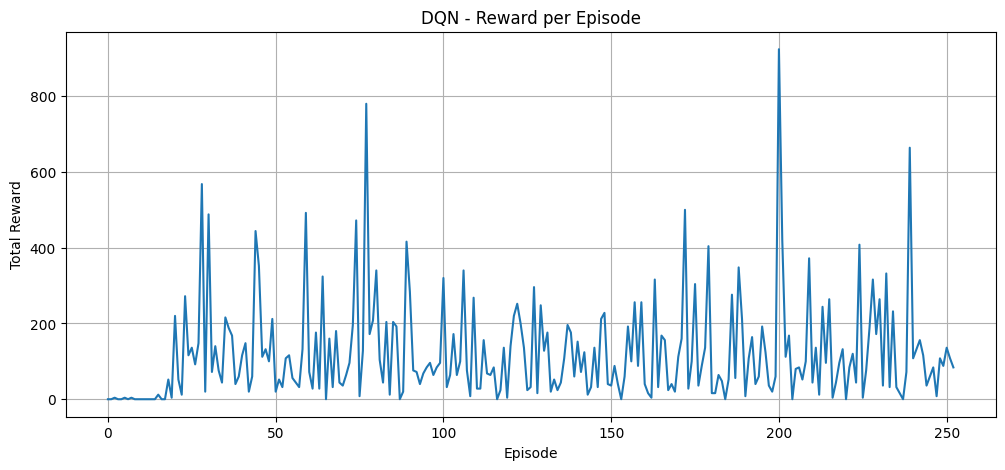

In [23]:
model = DQN("MultiInputPolicy", env, verbose=1, device="cpu")
model.learn(total_timesteps=10000)
model.save("models/dqn_citation_recommender")

# ===============================
# Plot Rewards
# ===============================

rewards = env.get_episode_rewards()
plt.figure(figsize=(12, 5))
plt.plot(rewards)
plt.title("DQN - Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()



In [40]:
len(rewards)

253

253


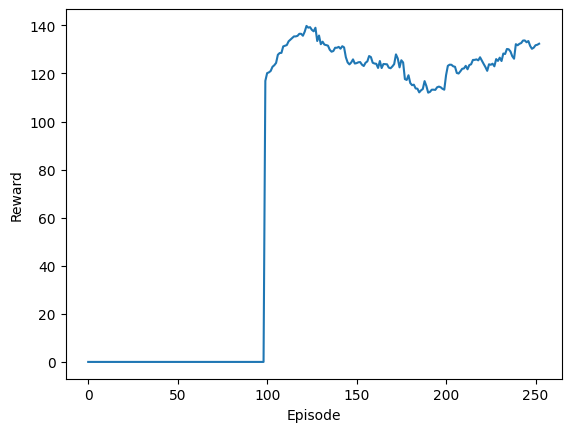

In [44]:
import torch
def plot_rewards(episode_rewards, window_size=100):
    rewards_t = torch.tensor(episode_rewards, dtype=torch.float)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    if len(rewards_t) >= window_size:
        means = rewards_t.unfold(0, window_size, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(window_size-1), means))
        print(len(means))
        plt.plot(means.numpy())

plot_rewards(rewards)


In [28]:
model.save("models/dqn_citation_recommender_llm")

In [ ]:
# ===============================
# Top-K Citation Recommendations for a User
# ===============================


# Reset environment to get a new user
obs = env.reset()[0]

# Simulate top-K
K = 5
recommended_items = []

for _ in range(K):
    action, _ = model.predict(obs, deterministic=True)
    item_id = env.unwrapped.action_to_item[int(action)]
    citation = env.unwrapped.items_loader.load_items_from_ids([item_id])[0]
    recommended_items.append(citation)
    obs, reward, done, truncated, info = env.step(action)

# Display user info
user_info = env.unwrapped._user
print(f"\n👤 User: {user_info.name}")
print(f"   Description: {user_info.description}")

# Display recommended papers
print("\n📚 Top-K Recommended Papers:")
for idx, citation in enumerate(recommended_items):
    print(f"\n[{idx+1}] Title: {citation.title}")
    print(f"    Year: {citation.year}")
    print(f"    Topics: {citation.topics}")
    print(f"    Citations: {citation.cited_by_count}")
    print(f"    Norm Year: {citation.norm_year:.2f} | Norm Citations: {citation.norm_cite:.2f}")
